In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

import torch

from helper.painter import Painter
from helper.trainer import Trainer
from helper.data_generator import DataGenerator
from helper.loader import Loader
from helper.cond_encoder import CLIPEncoder

from auto_encoder.models.variational_auto_encoder import VariationalAutoEncoder
from clip.models.ko_clip import KoCLIPWrapper
from diffusion_model.sampler.ddim import DDIM
from diffusion_model.models.latent_diffusion_model import DiffusionModel
from diffusion_model.network.unet import Unet
from diffusion_model.network.unet_wrapper import UnetWrapper

/vast/home/avuong/.conda/envs/diff/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import tqdm
from helper.util import extract

In [3]:
# Load test data
transform = transforms.Compose([transforms.Resize(32), 
                                transforms.ToTensor()])
test_data = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

batch_size = 128
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [4]:
# Path to the configuration file
CONFIG_PATH = './configs/cifar10_config.yaml'


# Set device
device = torch.device('cuda')

# Instantiate helper classes
painter = Painter()
loader = Loader()
data_generator = DataGenerator()

# Load CIFAR-10 dataset
data_loader = data_generator.cifar10(batch_size=2)

In [5]:
sampler = DDIM(CONFIG_PATH)  # Initialize the DDIM sampler
network = UnetWrapper(Unet, CONFIG_PATH, None)  # Initialize the U-Net network
dm = DiffusionModel(network, sampler, [3,32,32])  # Initialize the LDM

In [6]:
dm = loader.model_load('models/cifar10/dm', dm, is_ema=True)
# dm = loader.model_load('dm', dm, is_ema=True)

Epoch: 707
Training step: 34643
Best loss: 0.017362909505561908
Batch size: 1024
Number of batches: 49
===Model loaded!===


50it [00:00, 61.72it/s]


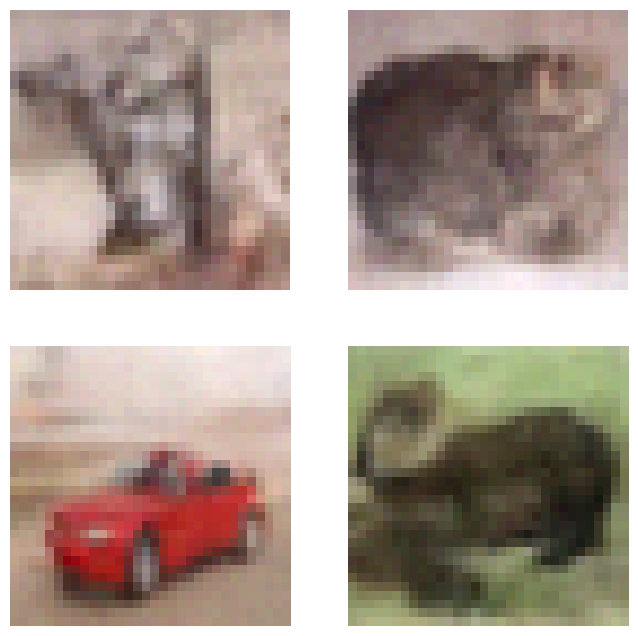

In [7]:
# Generate samples using the trained latent diffusion model
dm.eval()
dm = dm.to(device)
sample = dm.forward(n_samples=4)  # Generate 4 sample images, 'y' represents any conditions, 'gamma' means guidance scale
painter.show_images(sample)

In [8]:
sampler=sampler.to(device)
dm = dm.to(device)

sampler.eval()
dm.eval()

DiffusionModel(
  (sampler): DDIM(
    (network): UnetWrapper(
      (network): Unet(
        (init_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (time_mlp): Sequential(
          (0): SinusoidalEmbedding()
          (1): Linear(in_features=64, out_features=256, bias=True)
          (2): GELU(approximate='none')
          (3): Linear(in_features=256, out_features=256, bias=True)
        )
        (downs): ModuleList(
          (0): ModuleList(
            (0-1): 2 x ResnetBlock(
              (block1): Block(
                (norm): AdaptiveGroupNorm(
                  (norm): GroupNorm(32, 64, eps=1e-05, affine=False)
                  (gamma_proj): Linear(in_features=256, out_features=64, bias=True)
                  (beta_proj): Linear(in_features=256, out_features=64, bias=True)
                )
                (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (act): SiLU()
                (dropout): Dropout

## compute jacobian

In [14]:
N_sim = 1000
skip = 10
Js = []
batch_size = 1

def f(x, t):
    return dm.network(x, t.long())

pbar = tqdm.tqdm(range(1, N_sim, skip))
for t_in in pbar:
    Js_tmp = []
    # reset data
    data_loader = data_generator.cifar10(batch_size=batch_size)
    for idx, (x0, _) in enumerate(data_loader):
        pbar.set_description(f"batch {idx}")
        if idx >= 1: # collect from 128 images only
            break
        x0 = x0.to(device)
        
        t = torch.ones(batch_size,).long().to(device)*t_in
        x0_noised = sampler.q_sample(x0, t)
        
        # get scores & jacobian
        
        t_grad = t.clone().detach().requires_grad_(False)
        x_grad = x0_noised.clone().detach().requires_grad_(True).to(device)
        J, _ = torch.autograd.functional.jacobian(f, (x_grad, t_grad.float()), vectorize=True)
        Jr = J.reshape(batch_size, 3*32*32, batch_size, 3*32*32)
        Js_tmp.append(Jr.cpu().numpy())
    Js.append(Js_tmp)

np.save(f'stats/jacobian_t{N_sim}', np.array(Js))

batch 1: 100%|██████████| 100/100 [12:30<00:00,  7.51s/it]


## sample paths methods

In [11]:
def mike_periodic_bridge(x, y, steps):
    x = x.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    ## split in to pairs of pixels
    inds=np.arange(x.size).reshape((-1,1))
    xsize = x[0].size #size of 1 image
    # shuffle the indices
    for i in range(0, xsize*batch_size, xsize):
        tmp = inds[i:i+xsize]
        np.random.shuffle(tmp)
        inds[i:i+xsize] = tmp

    s = xsize // 2
    ind_pairs = np.array([np.stack((inds[i*s*2:i*s*2 + s], inds[i*s*2 + s:i*s*2 + 2*s])) for i in range(batch_size)])
    # print(ind_pairs.shape)
    centers = x[np.unravel_index(ind_pairs, x.shape)] # centers[:, i] == x[ind_pairs[0, i]], x[ind_pairs[1, i]] (where indexing is implicitly unraveled)
    points = y[np.unravel_index(ind_pairs, y.shape)]
    radii = np.sqrt(np.sum((centers - points) ** 2, axis=1))
    thetas = np.arctan2((points - centers)[:,1,...], (points - centers)[:,0,...])
    # print(centers.shape, points.shape, x.shape)
    
    radii = radii[:,None,:,:]
    thetas = thetas[:,None,:,:]
    # print(radii.shape, thetas.shape)
    
    def make_image(theta, x):
        new_points = centers + radii * np.concatenate([np.cos(thetas + theta), np.sin(thetas + theta)], axis=1)

        ind_0 = ind_pairs[:,0,...]
        ind_1 = ind_pairs[:,1,...]
        # print(new_points.shape)
        x[np.unravel_index(ind_0, x.shape)] = new_points[:,0,...]
        x[np.unravel_index(ind_1, x.shape)] = new_points[:,1,...]
        return x
        
    y_rot = np.zeros_like(x)
    bridge = []
    for i, theta in enumerate(np.linspace(0, 2*np.pi, steps, endpoint=False)):
        y_rot = make_image(theta, y_rot)
        bridge.append(torch.from_numpy(y_rot.copy()))

    bridge.append(bridge[0]) #closed-loop
    return bridge

def brownian_bridge(x, steps, sigma, T=1000):
    x_t = x.clone()
    bridge = [x_t.cpu()]
        
    # Construct Brownian bridge
    for t in range(1, T):
        eps = sigma * torch.randn_like(x)
        correction = (x - x_t) / (steps - t + 1)
        x_t = x_t + eps + correction
        bridge.append(x_t.cpu())
        
    # append initial point to form closed-loop
    bridge.append(bridge[0].cpu())
    return bridge

def cheapshot_bridge(x, steps, t):
    # generate steps//10 random images:
    bridge_tmp = []
    for i in range(steps//10):
        noise = torch.randn_like(x)
        tin = torch.ones(batch_size).long() * t
        xt = sampler.q_sample(x0, tin.to(device))
        bridge_tmp.append(xt.cpu())
    bridge_tmp.append(bridge_tmp[0]) # close loop
    
    bridge = [0 for i in range(steps+1)]
    bridge[0] = bridge_tmp[0]
    bridge[-1] = bridge_tmp[-1]
    
    for i in range(1, steps):
        if i%10 == 0:
            bridge[i] = bridge_tmp[i//10]
        else:
            alpha = (i%10)/10.0
            bridge[i] = (1-alpha)*bridge_tmp[i//10] + alpha*bridge_tmp[i//10+1]

    return bridge

def cheapshot_bridge_yt(x, t, size):
    def get_noised(x, t):
        tin = torch.ones(x.shape[0]).long() * t
        xt = sampler.q_sample(x0, tin.to(device))
        return xt
        
    def interpolate(X0, X1, X2, sqrt_alphas, sqrt_one_minus_alphas, L=100):
        # interpolate between X1->X2,
        # with projection back on to X0 manifold

        # linearly interpolate in between each dimension, as some initial guess
        X12 = np.zeros((x.shape[0], L, 3, size, size))
        
        # for b in range(x.shape[0]):
        #     for i in range(size):
        #         for j in range(size):
        #             for k in range(3):
        #                 X12[b,:,k,i,j] = np.interp( np.linspace(0,1,L), [0,1], [X1[b,k,i,j], X2[b,k,i,j]])

        # X1, X2: shape (B, 3, size, size)
        B, C, H, W = X1.shape
        t = np.linspace(0.0, 1.0, L, dtype=X1.dtype)[None, :, None, None, None]   # (1, L, 1, 1, 1)
        
        # Result: (B, L, 3, size, size)
        X12 = (1 - t) * X1[:, None, :, :, :] + t * X2[:, None, :, :, :]
    
        # matching the gamma from ddpm with YT's
        r1 = np.sqrt(np.sum(((X1 - X0*sqrt_alphas)/sqrt_one_minus_alphas)**2))
        r2 = np.sqrt(np.sum(((X2 - X0*sqrt_alphas)/sqrt_one_minus_alphas)**2))
        r_array = np.interp( np.linspace(0,1,L), [0,1], [r1,r2] ) 
    
        for i in range(L):
            unormalized = (X12[:,i,:] - X0*sqrt_alphas)/sqrt_one_minus_alphas
            projected = unormalized/ np.sqrt(np.sum(unormalized**2)) * r_array[i] #np.sqrt(32*32*3)
            X12[:,i,:] = X0*sqrt_alphas + projected*sqrt_one_minus_alphas
    
        X12 = torch.from_numpy(X12).permute(1,0,2,3,4).float() # first dim is the path
        X12 = list(X12)
        return X12
    tin = torch.ones(x.shape[0]).long() * t
    sqrt_alphas = extract(sampler.alpha_bar, tin.to(device), x.shape).detach().cpu().numpy()
    sqrt_one_minus_alphas = 1-sqrt_alphas
    
    X0 = x.detach().cpu().numpy()

    Xs = []
    for i in range(10): 
        Xs.append(get_noised(x, t).detach().cpu().numpy())
    Xs.append(Xs[0]) # closed-loop

    bridge = [torch.from_numpy(Xs[0])]
    for i in range(1,11):
        bridge += interpolate(X0, Xs[i-1], Xs[i], sqrt_alphas, sqrt_one_minus_alphas)[1:] # avoid duplicate
    
    return bridge

## run score calc

In [12]:
batch_size = 256
N_sim = 1000
skip = 10
T = 1000
for method in ['cheapshot_yt']:
# for method in ['brownian', 'rotation', 'cheapshot_yt']:
    # reset data
    test_loader = data_generator.cifar10(batch_size=batch_size, shuffle=False)

    # save variables
    int_list = []
    d_list = []
    int_norm_list = []
    
    # method = 'mike'
    sigma = 0.05
    # pbar = tqdm.tqdm(range(1, N_sim, skip))
    pbar = tqdm.tqdm(range(500, N_sim, skip))
    for t_in in pbar:
        max_iter = 1
        curr_iter = 0
        int_list_tmp = []
        int_norm_list_tmp = []
        d_norm_tmp = []
    
        
        for jdx, (x0,_) in enumerate(iter(test_loader)):
            if jdx >= max_iter:
                break
                
            x0 = x0.to(device)
            
            t = torch.ones(batch_size,).long().to(device)*t_in
            x0_noised = sampler.q_sample(x0, t)
    
            if method == 'brownian':
                bridge = brownian_bridge(x0_noised, T, 0.05)
            elif method == 'rotation':
                bridge = mike_periodic_bridge(x0, x0_noised, T)
            elif method == 'cheapshot':
                bridge = cheapshot_bridge(x0, T, t_in)
            elif method == 'cheapshot_yt':
                bridge = cheapshot_bridge_yt(x0, t_in, size=32)
            else:
                raise('You fucked up')
    
            # NORMAL PATH
            # calculate midpoint
            bridge_midpoint = []
            for i in range(len(bridge)-1):
                mid = (bridge[i] + bridge[i+1])/2
                bridge_midpoint.append(mid.cpu())
        
            # get scores
            scores = []
            t = torch.ones(batch_size,).to(device) * t_in
            t = t.long()
            for idx, xb in enumerate(bridge_midpoint):
                pbar.set_description(f"normal path: t_in={t_in}, jdx={jdx}, ddpm_iter={idx}")
                pred_n = dm.network(xb.to(device), t).detach().cpu()
                sqrt_alphas = extract(sampler.alpha_bar, t.to(device), x0.shape).detach().cpu()
                sqrt_one_minus_alphas = 1-sqrt_alphas
                scores.append(-pred_n/sqrt_one_minus_alphas)
    
            # get directions
            dirs = []
            for i in range(1, len(bridge)):
                dirs.append(bridge[i].cpu()-bridge[i-1].cpu())
            # path len
                
            # integrate
            int_res = np.zeros(batch_size)
            int_res_norm = np.zeros(batch_size)
            for s, d, m in zip(scores, dirs, bridge_midpoint):
                # calculate matrix inner prod of a batch
                # dxs = torch.einsum('ijkl,ijlm->ijkm', s, d) # <A.T,B>
                # norm = torch.vmap(torch.trace)(dxs[:,0,:,:]).numpy().ravel() # trace(<A,B>)
    
                dxs = s*d
                norm = torch.sum(dxs, (1,2,3)).detach().numpy().ravel()
                int_res += norm
                norm_ = norm/torch.linalg.vector_norm(m.detach(), dim=(1,2,3)).numpy().reshape(-1,)
                int_res_norm += norm_ # normalized by ||xt||
                
            d_norm = np.zeros(batch_size)
            for i in range(len(dirs)):
                for j in range(batch_size):
                    d_norm[j] += np.linalg.norm(dirs[i][j].detach().cpu().numpy())
                
            int_list_tmp += list(int_res)
            int_norm_list_tmp += list(int_res_norm)
            d_norm_tmp += list(d_norm)
        
        int_list.append(int_list_tmp)
        int_norm_list.append(int_norm_list_tmp)
        d_list.append(d_norm_tmp)

    dict_save = {
        'int_array': np.array(int_list),
        'int_norm_array': np.array(int_norm_list),
        'd_array': np.array(d_list)
    }

    # np.save(f'stats/{method}_walk_t{N_sim}_untrained_simplified', dict_save)
    np.save(f'stats/{method}_walk_t{N_sim}_simplified_second_half', dict_save)

    del dict_save # save some memory 
        
    # int_array = np.array(int_list)
    # np.save(f'{method}_normal_walk_t1000', int_array)


normal path: t_in=990, jdx=0, ddpm_iter=989: 100%|█████| 50/50 [1:50:47<00:00, 132.94s/it]


### normal boxplot

In [19]:
method = 'cheapshot_yt'
int_array = np.load('stats/cheapshot_yt_walk_t20_simplified.npy', allow_pickle=True)

In [20]:
ind = list(range(1, 100, 10))

In [21]:
import matplotlib.pyplot as plt

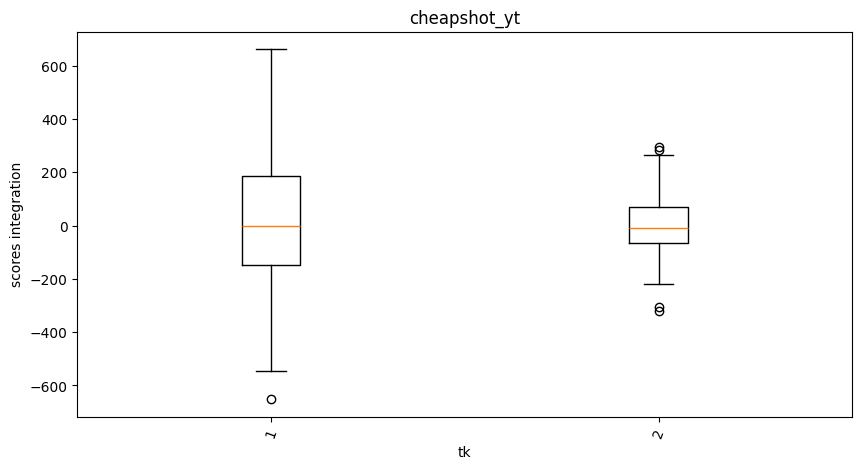

In [23]:
fig = plt.figure(figsize=(10,5))
plt.boxplot(list(int_array.ravel()[0]['int_array']))
plt.ylabel('scores integration')
plt.xlabel('tk')
plt.xticks(rotation=70)
plt.title(f"{method}")
plt.show()